# Summer School on Biomedical Imaging with Deep Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/albarqounilab/BILD-Summer-School/blob/main/notebooks/day1/preprocessing_dataloaders_solution.ipynb)

![alt_text](https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/helpers/notebook-banner.png)

BILD 2025 is organized under the umbrella of the [Strategic Arab-German Network for Affordable and Democratized AI in Healthcare (SANAD)](https://albarqouni.github.io/funded/sanad/), uniting academic excellence and technological innovation across borders. This year’s edition is organized by the [Albarqouni Lab](https://albarqouni.github.io/) at the [University Hospital Bonn](https://www.ukbonn.de/) and the [University of Bonn](https://www.uni-bonn.de/en). We are proud to partner with leading institutions in the region—Lebanese American University, University of Tunis El Manar, and Duhok Polytechnic University — to deliver a truly international learning experience. Over five intensive days in Tunis, you will explore cutting-edge deep-learning techniques for medical imaging through expert lectures, hands-on labs, and collaborative case studies. Engage with peers and faculty from Germany, Lebanon, Iraq, and Tunisia as you develop practical skills in building and deploying AI models for real-world healthcare challenges. We look forward to an inspiring week of interdisciplinary exchange and the shared commitment to advancing affordable, life-saving AI in medicine.


#  🩺 Object Detection

This notebook delves into the task of object detection, aiming to build a model that can locate signs of pneumonia in chest X-rays. It covers the entire data preparation pipeline: from loading complex medical images in the DICOM format to parsing the coordinates for the bounding boxes. The ultimate goal is to train a detector capable of drawing precise boxes around infected lung areas, a crucial step in assisting with medical diagnosis.

## Dataset description

**RSNA Pneumonia Detection Challenge**  
  The [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/overview) contains about 30,000 DICOM‑format chest X‑rays with expert‑drawn bounding boxes around pneumonia opacities, making it ideally suited for training and evaluating bounding‑box detection models (e.g., Faster R‑CNN, anchor‑free detectors).

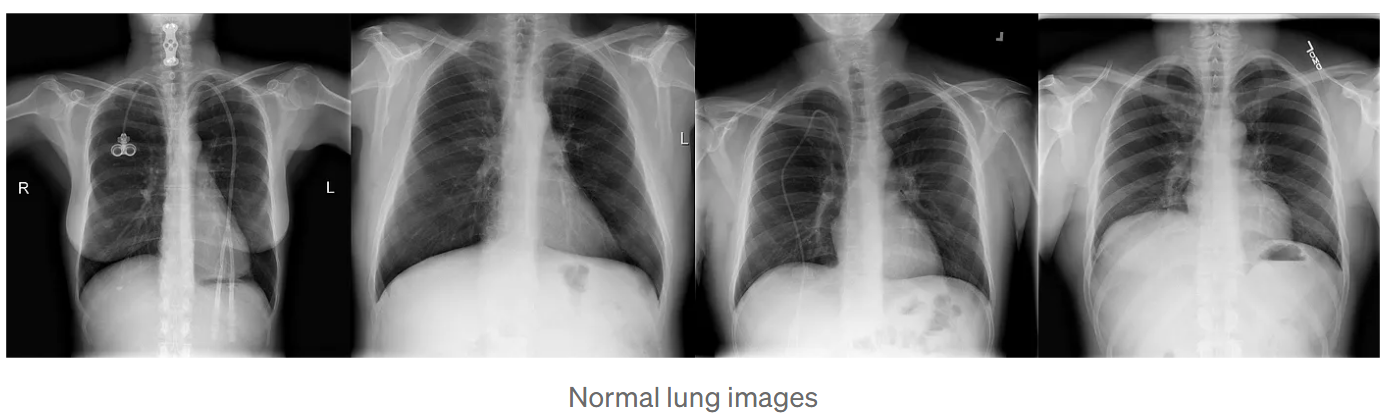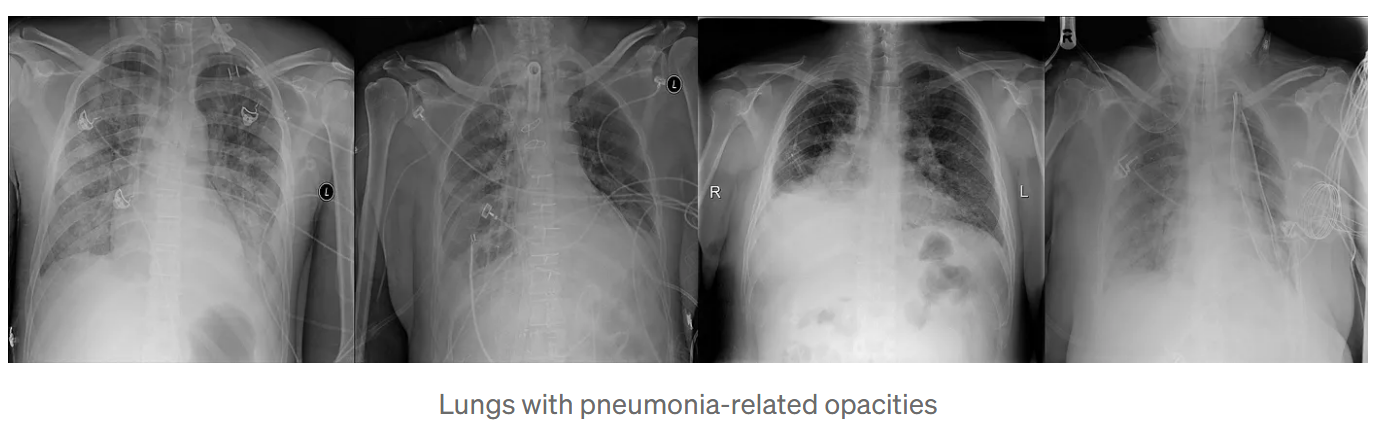

## Data Acquisition & Preparation

This first section handles getting the data. It installs Git LFS (for large files), clones the dataset repository from Hugging Face, and selectively pulls only the files needed for the detection task. Finally, it unzips the main dataset file, making the images and labels accessible for the rest of the script.

In [1]:
!apt-get install git-lfs -qq
# Clone the dataset repository
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/albarqouni/bild-dataset

%cd bild-dataset
!git lfs pull --include "Detection/*"
!unzip Detection/rsna-pneumonia-detection-challenge.zip -d Detection/dataset

Output streaming troncato alle ultime 5000 righe.
  inflating: Detection/dataset/rsna-pneumonia-detection-challenge/images/f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: Detection/dataset/__MACOSX/rsna-pneumonia-detection-challenge/images/._f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: Detection/dataset/rsna-pneumonia-detection-challenge/images/bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: Detection/dataset/__MACOSX/rsna-pneumonia-detection-challenge/images/._bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: Detection/dataset/rsna-pneumonia-detection-challenge/images/4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: Detection/dataset/__MACOSX/rsna-pneumonia-detection-challenge/images/._4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: Detection/dataset/rsna-pneumonia-detection-challenge/images/eb056e61-98f0-418d-a5e9-b82bd8d2db93.dcm  
  inflating: Detection/dataset/__MACOSX/rsna-pneumonia-detection-challenge/images/._eb056e61-98f0-418d-a5

In [2]:
# check the content of the directory
!ls -lh Detection/

total 3.5G
drwxr-xr-x 4 root root 4.0K Aug 15 08:58 dataset
-rw-r--r-- 1 root root 159M Aug 15 08:56 fasterrcnn_resnet50_fpn.pth
-rw-r--r-- 1 root root 3.4G Aug 15 08:57 rsna-pneumonia-detection-challenge.zip


## Setup and Imports




> **(TODO: Check that all these packages are needed for real)**




In [3]:
import os, sys, math, random, json, time, warnings, cv2
from glob import glob
from tqdm import tqdm
from pathlib import Path
from torchvision import tv_tensors

!pip install pydicom -q
import pydicom

!pip install SimpleITK -q
import SimpleITK as sitk

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    HAS_ALBU = True
except Exception:
    HAS_ALBU = False

# # Optional: used in segmentation (DICOM/NIfTI utilities)
# try:
#     import pydicom
#     import SimpleITK as sitk
#     sitk.ProcessObject.SetGlobalWarningDisplay(False)
#     HAS_SITK = True
# except Exception:
#     HAS_SITK = False

import torchvision
from torchvision import transforms

warnings.filterwarnings("ignore")

# Reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Albumentations installed:", HAS_ALBU)
# print("SimpleITK installed:", HAS_SITK)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.0 MB/s eta 0:00:00
Device: cuda
Albumentations installed: True


### Utility helpers

These are custom functions created to simplify repetitive tasks. `show_images_grid` is used for displaying multiple images in a neat grid, while `draw_bboxes_on_image` is specifically for visualizing an image with its bounding box labels drawn on top. Creating helpers like this makes the main code cleaner and easier to read.

In [4]:
# Plotting helpers
def show_images_grid(images, titles=None, ncols=4, figsize=(12, 8)):
    n = len(images)
    ncols = min(ncols, n) if n > 0 else 1
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i < n:
            img = images[i]
            if torch.is_tensor(img):
                img = img.detach().cpu()
                if img.ndim == 3 and img.shape[0] in (1,3):
                    img = img.permute(1,2,0)
            if isinstance(img, np.ndarray) and img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if titles and i < len(titles) and titles[i] is not None:
                ax.set_title(str(titles[i]))
    plt.tight_layout()
    plt.show()


def draw_bboxes_on_image(img, boxes, labels=None, linewidth=2):
    """Draw PASCAL VOC boxes [[x_min,y_min,x_max,y_max], ...] on a HxWxC image array."""
    if torch.is_tensor(img):
        img = img.detach().cpu()
        if img.ndim == 3 and img.shape[0] in (1,3):
            img = img.permute(1,2,0)
        img = img.numpy()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img, cmap=None if img.ndim==3 else 'gray')
    for i, b in enumerate(boxes):
        x1, y1, x2, y2 = [float(v) for v in b]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=linewidth, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if labels is not None:
            ax.text(x1, y1-2, str(labels[i]), color='w', fontsize=9,
                    bbox=dict(facecolor='r', alpha=0.5, pad=1))
    ax.axis('off')
    plt.tight_layout()
    plt.show()


def overlay_mask(img, mask, alpha=0.4):
    """Overlay a binary (or multi-class) mask on an image (H,W or H,W,3)."""
    if torch.is_tensor(img): img = img.detach().cpu()
    if torch.is_tensor(mask): mask = mask.detach().cpu()
    if img.ndim == 3 and img.shape[0] in (1,3):
        img = img.permute(1,2,0)
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    img_np = img.numpy() if isinstance(img, torch.Tensor) else np.array(img)
    mask_np = mask.numpy() if isinstance(mask, torch.Tensor) else np.array(mask)

    # Normalize for display
    img_disp = img_np.copy()
    if img_disp.dtype != np.uint8:
        img_disp = (img_disp - img_disp.min()) / (img_disp.ptp() + 1e-6)
    if img_disp.ndim == 2:
        img_disp = np.stack([img_disp]*3, axis=-1)

    # Colorize mask
    if mask_np.ndim == 2:
        color = np.zeros_like(img_disp)
        color[..., 0] = (mask_np > 0).astype(float)  # red
        out = (1 - alpha) * img_disp + alpha * color
    else:
        # multi-channel one-hot (C,H,W) -> simple argmax colormap
        onehot = mask_np
        if onehot.shape[0] < 3:
            # pad to 3
            pad = np.zeros((3 - onehot.shape[0], *onehot.shape[1:]), dtype=onehot.dtype)
            onehot = np.concatenate([onehot, pad], axis=0)
        idx = np.argmax(onehot, axis=0)
        cmap = np.array([[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1]], dtype=float)
        overlay = cmap[idx % len(cmap)]
        out = (1 - alpha) * img_disp + alpha * overlay
    plt.figure(figsize=(6,6)); plt.imshow(out); plt.axis('off'); plt.tight_layout(); plt.show()


def fast_dataloader_kwargs():
    cpu = os.cpu_count() or 2
    return dict(num_workers=min(4, cpu), pin_memory=torch.cuda.is_available())


## Data Exploration and Analysis


This part performs an initial exploratory data analysis (EDA). It uses the pandas library to load the CSV file containing labels and calculates key statistics, such as the number of patients with pneumonia. It then visualizes a single DICOM image and plots its corresponding bounding box, providing a first look at the data and the detection challenge.

### Load patient's splits


- Labels CSV at: `{DATA_PATH}/data/rsna-pneumonia-detection-challenge/labels.csv`
- DICOM image directory: `{DATA_PATH}/data/rsna-pneumonia-detection-challenge/images`
- The CSV contains columns: `patientId`, `Target` (1 if pneumonia), and bounding boxes (`x`, `y`, `width`, `height`) where applicable.

We build a dataset that reads DICOM, applies augmentations, and returns targets in the common PyTorch detection format:
```python
{
  "boxes": FloatTensor[N,4] in [x_min, y_min, x_max, y_max] (PASCAL VOC),
  "labels": LongTensor[N] (class ids; here 1=pneumonia, 0=background not returned),
  "image_id": Tensor[1],
  "area": FloatTensor[N],
  "iscrowd": Tensor[N]
}
```
We also define a `collate_fn` that stacks images and keeps a **list** of target dicts.


In [5]:
#@title Helpers
from torchvision.utils import draw_bounding_boxes
!pip install pycocotools
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
import utils
from engine import train_one_epoch, evaluate

Explore the structure of the labels with bounding boxes. How many positive samples (with pneumonia) are in the dataset? What proportion of images contain multiple bounding boxes?

In [6]:
# os.getcwd()
DATA_PATH = os.path.join(os.getcwd(), 'Detection/dataset')
RSNA_LABELS = f'{DATA_PATH}/rsna-pneumonia-detection-challenge/labels.csv'
RSNA_IMGDIR = f'{DATA_PATH}/rsna-pneumonia-detection-challenge/images'

assert os.path.exists(RSNA_LABELS), f"Missing {RSNA_LABELS}"
assert os.path.exists(RSNA_IMGDIR), f"Missing {RSNA_IMGDIR}"

dataset_df = pd.read_csv(RSNA_LABELS)

In [7]:
positive_samples = dataset_df[dataset_df["Target"] == 1]["patientId"].nunique()
total_samples = dataset_df["patientId"].nunique()
print(f"Positive cases: {positive_samples} / {total_samples}")

Positive cases: 6012 / 26684


In [8]:
dataset_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [9]:
# Images with multiple bbox
multiple_boxes = dataset_df[dataset_df["Target"] == 1].groupby("patientId").size()
print(f"Images with >1 bounding box: {(multiple_boxes > 1).sum()}")

Images with >1 bounding box: 3398


Here, we visualize the bounding box on an example image. What challenges might arise in detecting these regions?

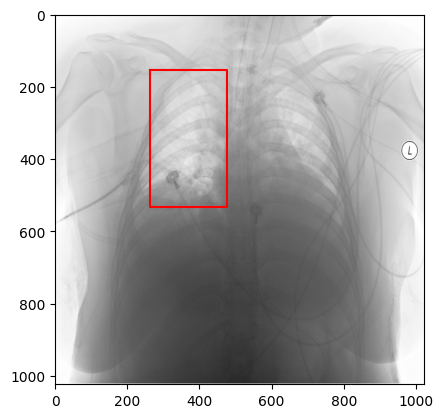

In [10]:
patient_df = dataset_df[dataset_df.Target == 1].iloc[0]
image_dir = f'{DATA_PATH}/rsna-pneumonia-detection-challenge/images'
img_path = os.path.join(image_dir, "{}.dcm".format(patient_df.patientId))

plt.imshow(pydicom.dcmread(img_path).pixel_array, 'Greys')

img_size = 1024
x, y, w, h = patient_df[['x', 'y', 'width', 'height']].values
plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], 'red')

In [11]:
patient_df

,4
patientId,00436515-870c-4b36-a041-de91049b9ab4
x,264.0
y,152.0
width,213.0
height,379.0
Target,1


## PyTorch Dataset Definition


his is a crucial step for working with PyTorch. The `PredictionDataset` class defines how to load and process the data. The `__getitem__` function specifies the exact steps for loading a single sample: it reads the **DICOM** image file, converts it into a format the model can use (a **tensor**), and pairs it with its corresponding bounding box coordinates and labels.

In [26]:
class PredictionDataset(Dataset):
    def __init__(self, dataframe, image_dir, target_size=(256, 256), transforms=None):
        super().__init__()

        self.image_ids = dataframe['patientId'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.target_size = target_size
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['patientId'] == image_id]

        # Load DICOM image
        image_dicom = pydicom.dcmread(f'{self.image_dir}/{image_id}.dcm')
        image = image_dicom.pixel_array

        # Store original dimensions
        original_height, original_width = image.shape

        # Convert to RGB and normalize
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1))  # (H,W,C) -> (C,H,W)
        image = tv_tensors.Image(image)

        # Resize image
        resize_transform = torchvision.transforms.Resize(self.target_size)
        resized_img = resize_transform(image)

        # Get target dimensions
        target_height, target_width = self.target_size

        # Calculate scaling factors
        scale_x = target_width / original_width
        scale_y = target_height / original_height

        # Process bounding boxes
        boxes = records[['x', 'y', 'width', 'height']].values.copy()

        # Convert from (x, y, width, height) to (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y + height

        # Scale bounding boxes to match resized image
        boxes[:, 0] *= scale_x  # x_min
        boxes[:, 1] *= scale_y  # y_min
        boxes[:, 2] *= scale_x  # x_max
        boxes[:, 3] *= scale_y  # y_max

        # Ensure boxes are within image bounds
        boxes[:, 0] = np.clip(boxes[:, 0], 0, target_width)   # x_min
        boxes[:, 1] = np.clip(boxes[:, 1], 0, target_height)  # y_min
        boxes[:, 2] = np.clip(boxes[:, 2], 0, target_width)   # x_max
        boxes[:, 3] = np.clip(boxes[:, 3], 0, target_height)  # y_max

        # Calculate area after scaling
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels (pneumonia class = 1)
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # No crowd instances
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # Create target dictionary
        target = {}
        target['boxes'] = tv_tensors.BoundingBoxes(
            boxes,
            format="XYXY",
            canvas_size=self.target_size  # Use actual image size after resize!
        ).float()
        target['labels'] = labels
        target['patientId'] = torch.tensor([index]).float()
        target['area'] = area.float()
        target['iscrowd'] = iscrowd

        # Apply additional transforms if provided
        if self.transforms:
            resized_img, target = self.transforms(resized_img, target)

        return resized_img.float(), target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

## Data Splitting and `DataLoader` Creation

This part prepares the data for a standard machine learning workflow. It uses scikit-learn to split the data into training, validation, and test sets. It then creates instances of the PredictionDataset for each split and wraps them in PyTorch DataLoaders. These DataLoaders are powerful tools that efficiently feed data to the model in shuffled batches

In [31]:
patient_list = dataset_df['patientId'].unique()

patient_train, patient_test = train_test_split(
    patient_list, # List or array to split
    test_size=0.2, # Size of the subset
    random_state=42)

patient_train, patient_val = train_test_split(
    patient_train,
    test_size=0.1 / 0.8,
    random_state=42)

train_df = dataset_df.loc[dataset_df['patientId'].isin(patient_train)]
val_df = dataset_df.loc[dataset_df['patientId'].isin(patient_val)]
test_df = dataset_df.loc[dataset_df['patientId'].isin(patient_test)]

train_df_pos = train_df[train_df.Target == 1]
val_df_pos = val_df[val_df.Target == 1]
test_df_pos = test_df[test_df.Target == 1]

train_dataset = PredictionDataset(train_df_pos, image_dir, target_size=(256, 256))
val_dataset = PredictionDataset(val_df_pos, image_dir, target_size=(256, 256))
test_dataset = PredictionDataset(test_df_pos, image_dir, target_size=(256, 256))

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn = utils.collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn = utils.collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn = utils.collate_fn
)

The `show_detection_batch` function grabs one batch of data from the `train_dataloader` and displays the images with their ground-truth bounding boxes drawn on them. This visually confirms that the entire data pipeline—from downloading and unzipping to processing within the `Dataset` class—is working correctly before you proceed to model training.

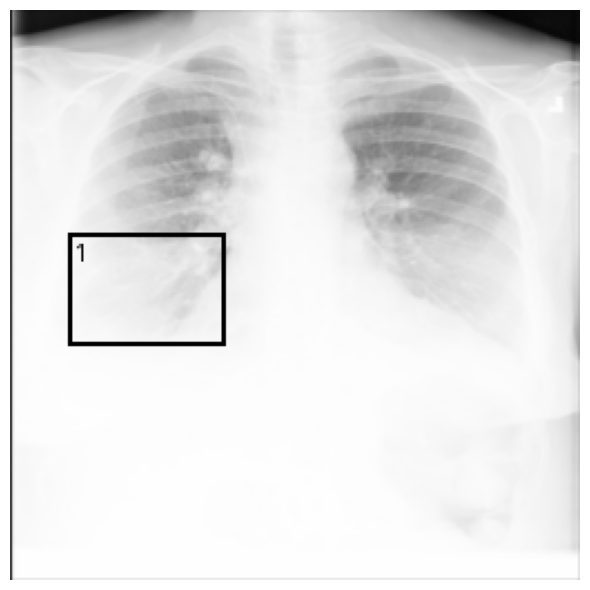

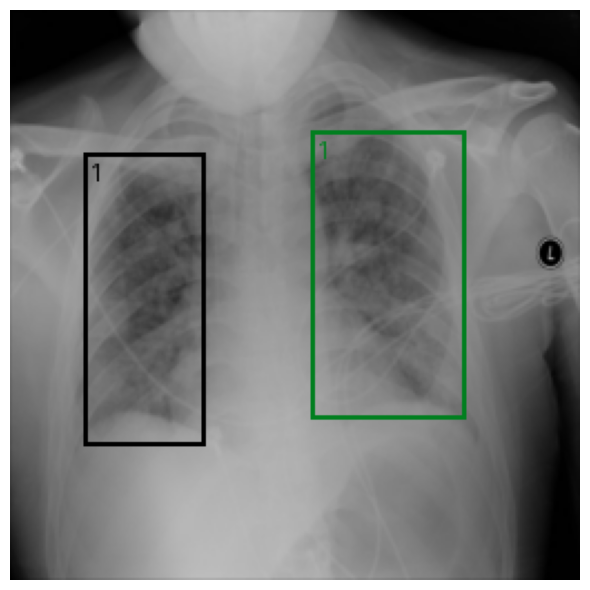

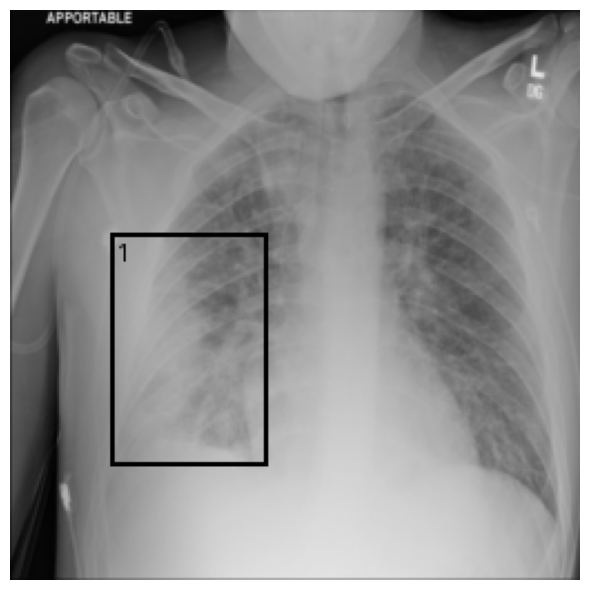

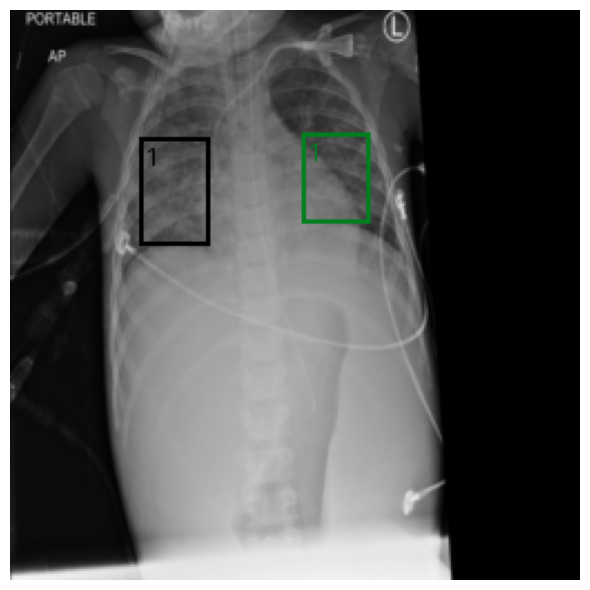

In [28]:
def show_detection_batch(dataloader, n=4, class_names=None):
    images, targets = next(iter(dataloader))

    k = min(n, len(images))
    for i in range(k):
        img = images[i]
        boxes = targets[i]['boxes']
        labels = targets[i].get('labels', None)

        img_uint8 = (img.clamp(0, 1) * 255).to(torch.uint8).cpu()

        # boxes tensor on CPU (keep as-is; format already XYXY)
        if isinstance(boxes, tv_tensors.BoundingBoxes):
            boxes_t = boxes.as_subclass(torch.Tensor).cpu()
        else:
            boxes_t = torch.as_tensor(boxes, dtype=torch.float32).cpu()

        # optional label strings
        label_strs = None
        if labels is not None:
            if isinstance(labels, torch.Tensor):
                labels = labels.cpu()
            if class_names is not None:
                label_strs = [class_names[int(l)] for l in labels]
            else:
                label_strs = [str(int(l)) for l in labels]

        drawn = draw_bounding_boxes(
            img_uint8, boxes_t, labels=label_strs, width=2
        )  # [C,H,W] uint8

        plt.figure(figsize=(6, 6))
        plt.imshow(drawn.permute(1, 2, 0))   # -> HWC
        plt.axis("off")
        plt.tight_layout()
        plt.show()
show_detection_batch(train_dataloader, n=4)


## Model Setup and Configuration

### Import Detection Model

We'll use a pre-trained Faster R-CNN model from torchvision, which is well-suited for medical imaging detection tasks.

In [29]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_detection_model(num_classes=2):  # background + pneumonia
    """
    Create a Faster R-CNN model for pneumonia detection.

    Args:
        num_classes (int): Number of classes (background + pneumonia = 2)

    Returns:
        torch.nn.Module: Configured Faster R-CNN model
    """
    # Load pre-trained model on COCO dataset
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize model
model = get_detection_model(num_classes=2)
model.to(device)
print(f"Model moved to: {device}")

Model moved to: cuda


### Configure Training Parameters

In [23]:
# import gc

# def clear_gpu_memory():
#     """Clear all GPU memory and cache."""
#     print("Clearing GPU memory...")

#     # Get the global namespace
#     import builtins
#     global_vars = globals() if hasattr(builtins, 'get_ipython') else locals()

#     # List of common variable names to delete
#     vars_to_delete = ['model']

#     # Delete variables if they exist
#     for var_name in vars_to_delete:
#         if var_name in global_vars:
#             print(f"Deleting {var_name}")
#             del global_vars[var_name]

#     # Force garbage collection
#     gc.collect()

#     # Clear PyTorch cache
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

#     # Print memory stats
#     if torch.cuda.is_available():
#         print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
#         print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
#     else:
#         print("CUDA not available")

#     print("Memory cleared!")

# # Run this first
# clear_gpu_memory()

Clearing GPU memory...
Deleting model
Deleting train_dataloader
Deleting val_dataloader
Deleting test_dataloader
Deleting train_dataset
Deleting val_dataset
Deleting test_dataset
Deleting optimizer
Deleting lr_scheduler
GPU memory allocated: 0.16 GB
GPU memory cached: 0.17 GB
Memory cleared!


In [32]:
# Training hyperparameters
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 10
STEP_SIZE = 3
GAMMA = 0.1

# Set up optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

print(f"Training configuration:")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Number of epochs: {NUM_EPOCHS}")
print(f"- Batch size: {train_dataloader.batch_size}")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Image shape: {train_dataset[0][0].shape}")

Training configuration:
- Learning rate: 0.005
- Number of epochs: 10
- Batch size: 8
- Training samples: 4205
- Validation samples: 578
- Image shape: torch.Size([3, 256, 256])


## Training Loop Implementation

### Training Function

In [33]:
def train_one_epoch_custom(model, optimizer, data_loader, device, epoch, print_freq=10):
    """
    Train the model for one epoch.

    Args:
        model: Detection model
        optimizer: Optimizer
        data_loader: Training data loader
        device: Device to train on
        epoch: Current epoch number
        print_freq: Print frequency for logging

    Returns:
        dict: Training metrics
    """
    model.train()

    total_loss = 0.0
    num_batches = 0

    for batch_idx, (images, targets) in enumerate(data_loader):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass - model returns losses during training
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += losses.item()
        num_batches += 1

        # Print progress
        if batch_idx % print_freq == 0:
            print(f'Epoch [{epoch}], Batch [{batch_idx}/{len(data_loader)}], '
                  f'Loss: {losses.item():.4f}')

            # Print individual loss components
            for k, v in loss_dict.items():
                print(f'  {k}: {v.item():.4f}')

    avg_loss = total_loss / num_batches
    return {'train_loss': avg_loss}

## Validation Function

The following cell defines a set of functions to evaluate an object detection model. They calculate the **Intersection over Union (IoU)** to measure how accurately the predicted boxes overlap with the true boxes, and then use this to compute overall performance metrics like **precision** and **recall**.

In [34]:
def validate_model(model, data_loader, device):
    """
    Validate the model and compute metrics.

    Args:
        model: Detection model
        data_loader: Validation data loader
        device: Device to evaluate on

    Returns:
        dict: Validation metrics
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            # Move data to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Store predictions and targets for metric calculation
            all_predictions.extend(predictions)
            all_targets.extend(targets)

    # Calculate validation metrics
    val_metrics = calculate_detection_metrics(all_predictions, all_targets)
    return val_metrics

def calculate_detection_metrics(predictions, targets, iou_threshold=0.5):
    """
    Calculate detection metrics (simplified version).

    Args:
        predictions: List of prediction dictionaries
        targets: List of target dictionaries
        iou_threshold: IoU threshold for considering a detection as correct

    Returns:
        dict: Computed metrics
    """
    total_predictions = 0
    total_targets = 0
    correct_predictions = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu()
        pred_scores = pred['scores'].cpu()
        pred_labels = pred['labels'].cpu()

        target_boxes = target['boxes'].cpu()
        target_labels = target['labels'].cpu()

        # Filter predictions by score threshold
        score_threshold = 0.5
        valid_preds = pred_scores > score_threshold
        pred_boxes = pred_boxes[valid_preds]
        pred_labels = pred_labels[valid_preds]

        total_predictions += len(pred_boxes)
        total_targets += len(target_boxes)

        # Simple IoU-based matching (simplified for tutorial)
        if len(pred_boxes) > 0 and len(target_boxes) > 0:
            # Calculate IoU between all predictions and targets
            ious = calculate_iou(pred_boxes, target_boxes)
            max_ious, _ = torch.max(ious, dim=1)
            correct_predictions += (max_ious > iou_threshold).sum().item()

    # Calculate metrics
    precision = correct_predictions / max(total_predictions, 1)
    recall = correct_predictions / max(total_targets, 1)
    f1_score = 2 * (precision * recall) / max(precision + recall, 1e-8)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'total_predictions': total_predictions,
        'total_targets': total_targets,
        'correct_predictions': correct_predictions
    }

def calculate_iou(boxes1, boxes2):
    """Calculate IoU between two sets of boxes."""
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Expand dimensions for broadcasting
    boxes1_expanded = boxes1.unsqueeze(1)  # [N, 1, 4]
    boxes2_expanded = boxes2.unsqueeze(0)  # [1, M, 4]

    # Calculate intersection
    inter_x1 = torch.max(boxes1_expanded[:, :, 0], boxes2_expanded[:, :, 0])
    inter_y1 = torch.max(boxes1_expanded[:, :, 1], boxes2_expanded[:, :, 1])
    inter_x2 = torch.min(boxes1_expanded[:, :, 2], boxes2_expanded[:, :, 2])
    inter_y2 = torch.min(boxes1_expanded[:, :, 3], boxes2_expanded[:, :, 3])

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

    # Calculate union
    area1_expanded = area1.unsqueeze(1)
    area2_expanded = area2.unsqueeze(0)
    union_area = area1_expanded + area2_expanded - inter_area

    # Calculate IoU
    iou = inter_area / torch.clamp(union_area, min=1e-8)

    return iou

## Main Training Loop

In [ ]:
def train_detection_model(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs, device):
    """
    Complete training loop with validation.

    Args:
        model: Detection model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer
        lr_scheduler: Learning rate scheduler
        num_epochs: Number of epochs to train
        device: Device to train on

    Returns:
        dict: Training history
    """
    print("Starting training...")
    print("=" * 60)

    history = {
        'train_loss': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'learning_rates': []
    }

    best_f1 = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        train_metrics = train_one_epoch_custom(
            model, optimizer, train_loader, device, epoch + 1
        )

        # Validation phase
        print("Validating...")
        val_metrics = validate_model(model, val_loader, device)

        # Update learning rate
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics
        history['train_loss'].append(train_metrics['train_loss'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1_score'])
        history['learning_rates'].append(current_lr)

        # Print epoch summary
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Train Loss: {train_metrics['train_loss']:.4f}")
        print(f"Val Precision: {val_metrics['precision']:.4f}")
        print(f"Val Recall: {val_metrics['recall']:.4f}")
        print(f"Val F1-Score: {val_metrics['f1_score']:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_metrics['f1_score'] > best_f1:
            best_f1 = val_metrics['f1_score']
            best_model_state = model.state_dict().copy()
            print(f"New best model! F1-Score: {best_f1:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with F1-Score: {best_f1:.4f}")

    return history

# Start training
training_history = train_detection_model(
    model, train_dataloader, val_dataloader, optimizer, lr_scheduler, NUM_EPOCHS, device
)

Starting training...

Epoch 1/10
----------------------------------------
Epoch [1], Batch [0/526], Loss: 1.3227
  loss_classifier: 1.0275
  loss_box_reg: 0.0863
  loss_objectness: 0.1900
  loss_rpn_box_reg: 0.0189
Epoch [1], Batch [10/526], Loss: 0.2773
  loss_classifier: 0.1017
  loss_box_reg: 0.1148
  loss_objectness: 0.0511
  loss_rpn_box_reg: 0.0097
Epoch [1], Batch [20/526], Loss: 0.3904
  loss_classifier: 0.1435
  loss_box_reg: 0.2081
  loss_objectness: 0.0294
  loss_rpn_box_reg: 0.0093
Epoch [1], Batch [30/526], Loss: 0.2876
  loss_classifier: 0.1026
  loss_box_reg: 0.1506
  loss_objectness: 0.0261
  loss_rpn_box_reg: 0.0083
Epoch [1], Batch [40/526], Loss: 0.3045
  loss_classifier: 0.1143
  loss_box_reg: 0.1670
  loss_objectness: 0.0187
  loss_rpn_box_reg: 0.0045
Epoch [1], Batch [50/526], Loss: 0.3194
  loss_classifier: 0.1192
  loss_box_reg: 0.1837
  loss_objectness: 0.0097
  loss_rpn_box_reg: 0.0068
Epoch [1], Batch [60/526], Loss: 0.3360
  loss_classifier: 0.1467
  loss_bo

In [ ]:
# Save model weight
def save_model(model, optimizer, history, filepath):
    """Save the trained model and training history."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_history': history,
        'model_config': {
            'num_classes': 2,
            'learning_rate': LEARNING_RATE,
            'num_epochs': NUM_EPOCHS
        }
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to: {filepath}")

def load_model(filepath, device):
    """Load a trained model."""
    checkpoint = torch.load(filepath, map_location=device)

    # Create model
    model = get_detection_model(num_classes=2)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    return model, checkpoint

# Save the trained model
model_save_path = 'pneumonia_detection_model.pth'
save_model(model, optimizer, training_history, model_save_path)

print(f"Training completed!")
print(f"Model saved to: {model_save_path}")
print(f"Best F1-Score achieved: {max(training_history['val_f1']):.4f}")

**TAKES APPROX 2 HOURS :( **

### Training Progress Visualization

In [ ]:
def plot_training_history(history):
    """Plot training metrics over time."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Training Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Validation Metrics
    axes[0, 1].plot(epochs, history['val_precision'], 'g-', label='Precision')
    axes[0, 1].plot(epochs, history['val_recall'], 'r-', label='Recall')
    axes[0, 1].plot(epochs, history['val_f1'], 'b-', label='F1-Score')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning Rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'orange', label='Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].set_yscale('log')

    # Combined metrics
    axes[1, 1].plot(epochs, history['val_f1'], 'b-', linewidth=2, label='F1-Score')
    axes[1, 1].set_title('Best Metric: F1-Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Results:")
    print("=" * 30)
    print(f"Best Validation F1-Score: {max(history['val_f1']):.4f}")
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Precision: {history['val_precision'][-1]:.4f}")
    print(f"Final Recall: {history['val_recall'][-1]:.4f}")

# Plot the training history
plot_training_history(training_history)

## Model Evaluation on Test Set

In [ ]:
def evaluate_on_test_set(model, test_loader, device):
    """
    Comprehensive evaluation on test set.

    Args:
        model: Trained detection model
        test_loader: Test data loader
        device: Device to evaluate on

    Returns:
        dict: Test metrics and predictions
    """
    print("Evaluating on test set...")
    model.eval()

    all_predictions = []
    all_targets = []
    all_images = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Testing"):
            # Move data to device
            images_device = [img.to(device) for img in images]
            targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images_device)

            # Store for analysis (move back to CPU)
            all_predictions.extend([{k: v.cpu() for k, v in pred.items()} for pred in predictions])
            all_targets.extend([{k: v.cpu() for k, v in target.items()} for target in targets])
            all_images.extend([img.cpu() for img in images])

    # Calculate comprehensive metrics
    test_metrics = calculate_detection_metrics(all_predictions, all_targets)

    print("\nTest Set Results:")
    print("=" * 30)
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"Total Predictions: {test_metrics['total_predictions']}")
    print(f"Total Ground Truth: {test_metrics['total_targets']}")
    print(f"Correct Predictions: {test_metrics['correct_predictions']}")

    return {
        'metrics': test_metrics,
        'predictions': all_predictions,
        'targets': all_targets,
        'images': all_images
    }

# Evaluate the model
test_results = evaluate_on_test_set(model, test_dataloader, device)

## Quality Control and Visualization

### Visualize Predictions vs Ground Truth

In [ ]:
def visualize_predictions(images, predictions, targets, num_samples=8, score_threshold=0.5):
    """
    Visualize model predictions alongside ground truth.

    Args:
        images: List of images
        predictions: List of prediction dictionaries
        targets: List of target dictionaries
        num_samples: Number of samples to visualize
        score_threshold: Minimum confidence score to display predictions
    """
    n_samples = min(num_samples, len(images))

    fig, axes = plt.subplots(2, n_samples//2, figsize=(20, 10))
    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        ax = axes[i]

        # Get image
        img = images[i]
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()

        # Display image
        ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)

        # Draw ground truth boxes (green)
        gt_boxes = targets[i]['boxes']
        for box in gt_boxes:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

        # Draw predictions (red)
        pred_boxes = predictions[i]['boxes']
        pred_scores = predictions[i]['scores']

        # Filter by score threshold
        valid_preds = pred_scores > score_threshold
        pred_boxes_filtered = pred_boxes[valid_preds]
        pred_scores_filtered = pred_scores[valid_preds]

        for box, score in zip(pred_boxes_filtered, pred_scores_filtered):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add confidence score
            ax.text(x1, y1-5, f'{score:.2f}', color='red', fontweight='bold')

        ax.set_title(f'Sample {i+1}\nGT: {len(gt_boxes)} boxes, Pred: {len(pred_boxes_filtered)} boxes')
        ax.axis('off')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Ground Truth'),
        Line2D([0], [0], color='red', lw=2, label='Predictions')
    ]
    fig.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Visualize test results
visualize_predictions(
    test_results['images'],
    test_results['predictions'],
    test_results['targets'],
    num_samples=8
)